In [1]:
# Uncomment to set up in Colab
#!pip install --quiet torchtyping
#!rm -rf bayesian-flow-networks
#!git clone https://github.com/javidlakha/bayesian-flow-networks.git

#import sys
#sys.path.append('bayesian-flow-networks')

In [2]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtyping import TensorType
from tqdm.auto import tqdm

from bfn import ContinuousBFN

In [3]:
def sine(
    batch_size: int,
    minimum: float = -np.pi,
    maximum: float = np.pi,
    device: Optional[torch.device] = 'cpu',
) -> TensorType['batch', 'sequence']:
  x = torch.linspace(minimum, maximum, batch_size)
  sin_x = torch.sin(x)
  X = torch.stack((x, sin_x), dim=1).to(device)
  return X

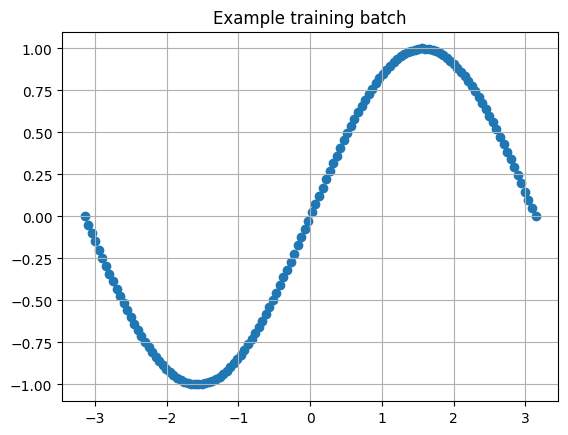

In [4]:
X = sine(128)
plt.title('Example training batch')
plt.scatter(X[:,0], X[:,1])
plt.grid()
plt.show()

In [5]:
class Net(nn.Module):
    def __init__(
        self,
        sequence_len: int,
        hidden_dim: int,
    ) -> None:
        super().__init__()
        self.input = nn.Linear(sequence_len + 1, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, sequence_len)

    def forward(
        self,
        x: TensorType['batch', 'sequence'],
        t: TensorType['batch'],
        **kwargs,
    ) -> TensorType['batch', 'sequence']:
        # Add time as a feature
        x = torch.cat((x, t[:, None]), dim=-1)

        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        x = self.output(x)

        return x

  0%|          | 0/4096 [00:00<?, ?it/s]

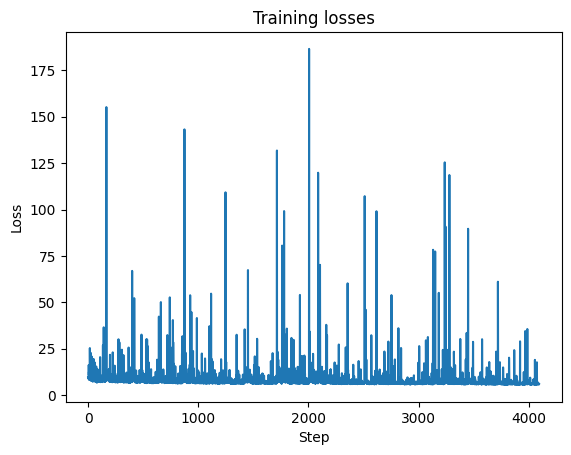

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sequence_len = 2
batch_size = 2**12
hidden_dim = 128
training_steps = 2**12

net = Net(sequence_len, hidden_dim)
bfn = ContinuousBFN(sequence_len, net)
bfn.to(device)

optimiser = optim.AdamW(bfn.parameters(), lr=1e-3)

losses = []
for i in tqdm(range(training_steps)):
    optimiser.zero_grad()
    batch = sine(batch_size, device=device)
    loss = bfn.continuous_time_loss(batch)
    loss.backward()
    optimiser.step()
    losses.append(loss.detach().item())

plt.title('Training losses')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

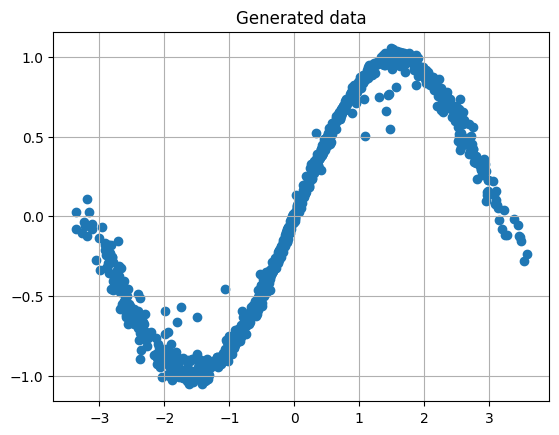

In [7]:
X = bfn.generate(
    batch_size=1024,
    steps=1024,
    device=device,
).cpu().numpy()

plt.title('Generated data')
plt.scatter(X[:,0], X[:,1])
plt.grid()
plt.show()